In [3]:
# Alternative shortest path algorithm: A* Algorithm
# The documentation of the A*-algorithm can be found here: https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html#module-networkx.algorithms.shortest_paths.astar

In [66]:
import networkx as nx
import osmnx


In [67]:
PLACE_NAME = "Bernkastel-Kues, Germany"
graph = osmnx.graph_from_place(
    "Bernkastel-Kues, Germany",
    network_type="bike"
)
# figure, ax = osmnx.plot_graph(graph)

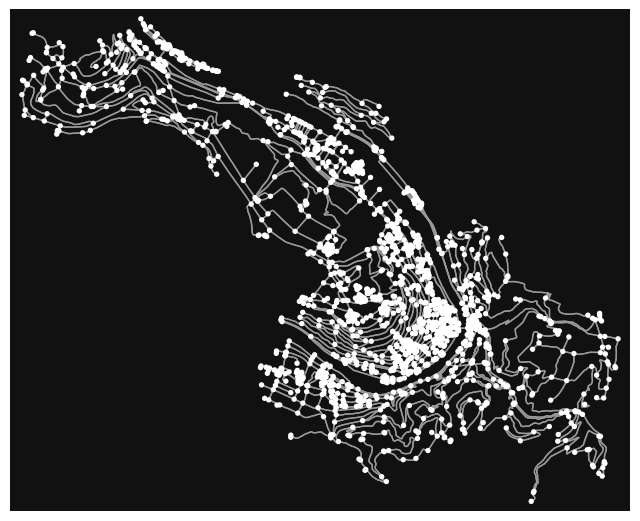

In [68]:
# Get the area of interest polygon
place_polygon = osmnx.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = osmnx.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="bike"
)

fig, ax = osmnx.plot_graph(graph)

In [69]:
# Show the data
# Retrieve only edges from the graph
edges = osmnx.graph_to_gdfs(graph, nodes=False, edges=True)
# edges.head()

In [70]:
# listing of all the different amounts of street-types
edges["highway"].value_counts()

highway
track                           1250
service                         1095
residential                      765
path                             690
secondary                        212
unclassified                     192
primary                          155
tertiary                          81
pedestrian                        50
[service, path]                   40
cycleway                          30
[track, path]                     26
[service, residential]            18
[residential, path]               18
[track, residential]              18
[service, track]                   8
[track, service]                   8
living_street                      6
tertiary_link                      5
[service, cycleway]                2
[service, unclassified]            2
[pedestrian, residential]          2
[track, residential, path]         2
[residential, unclassified]        2
[track, unclassified]              2
[residential, living_street]       1
Name: count, dtype: int64

In [71]:
# Transform the graph to UTM
graph = osmnx.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = osmnx.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [72]:
## 2. Analysing network properties

In [73]:
# Calculate network statistics
osmnx.basic_stats(graph)

{'n': 1857,
 'm': 4680,
 'k_avg': 5.040387722132472,
 'edge_length_total': 637250.7102022968,
 'edge_length_avg': 136.16468166715745,
 'streets_per_node_avg': 2.6984383414108777,
 'streets_per_node_counts': {0: 0, 1: 366, 2: 13, 3: 1299, 4: 174, 5: 4, 6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.19709208400646203,
  2: 0.007000538502961767,
  3: 0.6995153473344103,
  4: 0.09369951534733441,
  5: 0.002154011847065159,
  6: 0.0005385029617662897},
 'intersection_count': 1491,
 'street_length_total': 322850.87808835047,
 'street_segment_count': 2435,
 'street_length_avg': 132.58762960507207,
 'circuity_avg': 1.0995736409784624,
 'self_loop_proportion': 0.002053388090349076}

In [74]:
convex_hull = edges.geometry.union_all().convex_hull
# convex_hull
stats = osmnx.basic_stats(graph, area=convex_hull.area)
# stats

Total lenghts:
highway
residential    75480.329937
primary        19733.246455
secondary      32011.891966
Name: length, dtype: float64

The mean lenghts of the streets of the tree classes are:
highway
residential     91.380545
primary        127.311267
secondary      150.999490
Name: length, dtype: float64
The shortest is  residential  The longest is  secondary

The longest classes are:  highway
track          337.265721
path            91.565898
service         79.841168
residential     75.480330
secondary       32.011892
Name: length, dtype: float64


Text(0, 0.5, 'Total lenght (km)')

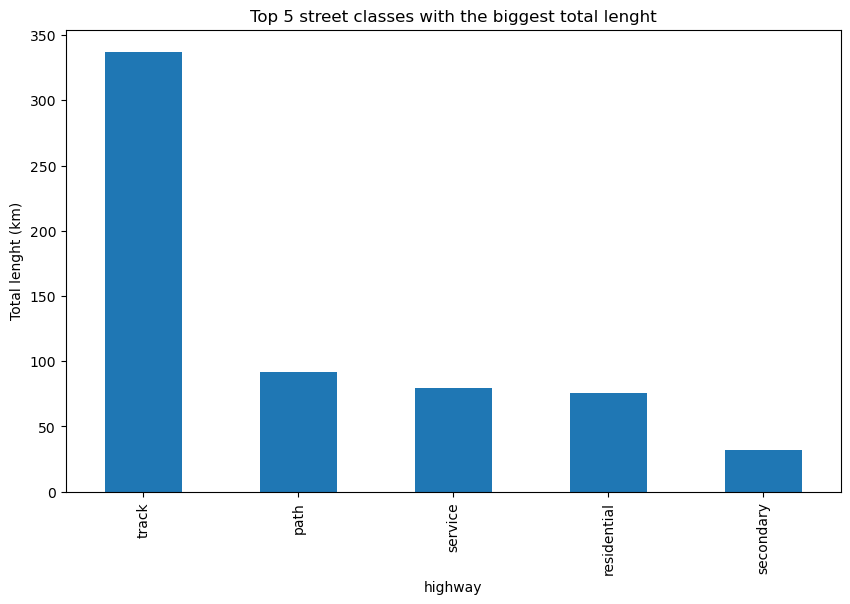

In [75]:
# Task 2.1
# 1. Calculate the total length of streets classified as residential, primary, and secondary.
# 2. Compare the mean length for each class.
# 3. Visualise the five longest street classes in a bar chart.

nodes, edges = osmnx.graph_to_gdfs(graph)
edges = edges.explode("highway")

# 1. Calculate the total length of streets classified as residential, primary, and secondary. 

# filter for the wanted classes
selected_classes = ['residential', 'primary', 'secondary']

lengths_by_class = edges.groupby('highway')['length'].sum()

# select the tree classes
selected_lengths = lengths_by_class[selected_classes]

print("Total lenghts:")
print(selected_lengths)

# 2. Compare the mean length for each class.
means_by_class = edges.groupby('highway')['length'].mean()
selected_means = means_by_class[selected_classes]
print()
print('The mean lenghts of the streets of the tree classes are:')
print(selected_means)

typ_sorted = selected_means.sort_values()
print('The shortest is ', typ_sorted.index[0], ' The longest is ', typ_sorted.index[2])

# 3.Visualise the five longest street classes in a bar chart.
import matplotlib.pyplot as plt

lengths_by_all_classes = edges.groupby('highway')['length'].sum()
longest_classes = (lengths_by_all_classes.sort_values(ascending=False)[0:5])/1000
print()
print('The longest classes are: ',longest_classes)
longest_classes.plot(kind='bar', figsize=(10, 6))
plt.title("Top 5 street classes with the biggest total lenght")
plt.ylabel("Total lenght (km)")

In [76]:
import math
import myst_nb

myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

46.7

637

In [77]:
# 3. Shortest path analysis

In [78]:
origin = (
    osmnx.geocode_to_gdf("Bernkastler Graben, bernkastel-kues, Germany")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    osmnx.geocode_to_gdf("Friedhof Kues, bernkastel-kues")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [79]:
# nearest node to the start and the end
origin_node_id = osmnx.nearest_nodes(graph, origin.x, origin.y)
destination_node_id = osmnx.nearest_nodes(graph, destination.x, destination.y)

In [80]:
# Find the shortest path between origin and destination
route = nx.astar_path(graph, origin_node_id, destination_node_id, heuristic=None, weight="length")
# Plot the shortest path
# fig, ax = osmnx.plot_graph_route(graph, route)

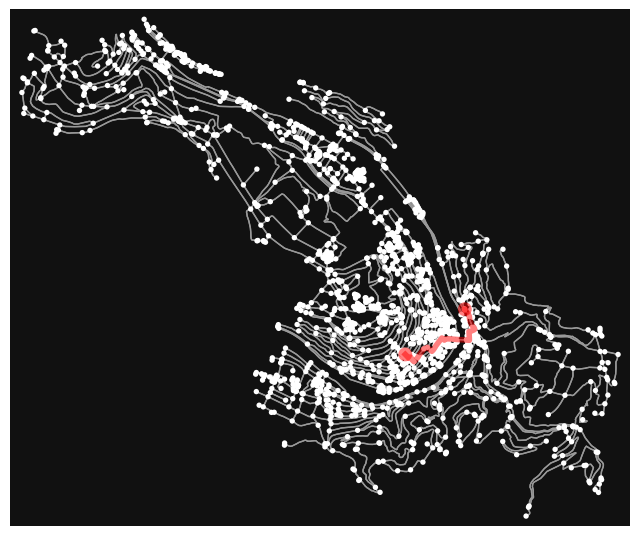

The lenght of the original route is  1.842  km
The lenght of the alternative route is  1.918  km
It is practical for a lot of usecases: Here I can imagine that a pedestrian wants to take a quiet walk, because the day is quite nice.


In [81]:
# Task 3.4 
# 1. Calculate a second route that avoids motorway and trunk streets.
# 2. Compare its length with the original shortest route.
# 3. Discuss in one sentence why constrained routes can be useful for certain users.

# 1. Calculate a second route that avoids motorway and trunk streets.
unwanted_classes = ['motorway', 'trunk']

# Setting the weight of the unwanted classes so high, that they are not used
for u, v, k, data in graph.edges(keys=True, data=True):
    # Normalize 'highway' to a list
    hw = data.get('highway', [])
    if isinstance(hw, str):
        hw = [hw]
    
    # Assign weight
    data['weight'] = 999 if any(h in unwanted_classes for h in hw) else 1

# edges = ox.graph_to_gdfs(graph, nodes=False)  
# print(edges)

# Calculate the route avoiding motorways/trunks
route_reduced = nx.astar_path(graph, origin_node_id, destination_node_id, heuristic=None, weight="weight")
fig, ax = osmnx.plot_graph_route(graph, route_reduced)

# 2. Compare its length with the original shortest route.
original_route_2 = ox.routing.route_to_gdf(graph, route)
length_ori = original_route_2["length"].sum()/1000
print('The lenght of the original route is ', round(length_ori,3), ' km')

alt_route_2 = ox.routing.route_to_gdf(graph, route_reduced, weight="weight")
length_alt = alt_route_2["length"].sum()/1000
print('The lenght of the alternative route is ',  round(length_alt, 3), ' km')

# 3. Discuss in one sentence why constrained routes can be useful for certain user
print('It is practical for a lot of usecases: Here I can imagine that a pedestrian wants to take a quiet walk, because the day is quite nice.')


In [82]:
# Saving the shortest path
# Get the nodes along the shortest path
route_nodes = nodes.loc[route]

import shapely.geometry

# Create a geometry for the shortest path
route_line = shapely.geometry.LineString(
    list(route_nodes.geometry.values)
)
route_line

import geopandas as gpd

route_geom = gpd.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()



,geometry,osm_nodes,length_m
0,"LINESTRING (361711.859 5531493.062, 361712.209...","[733945454, 472471993, 472471988, 12053760079,...",1829.759842


In [83]:
# download buildings
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

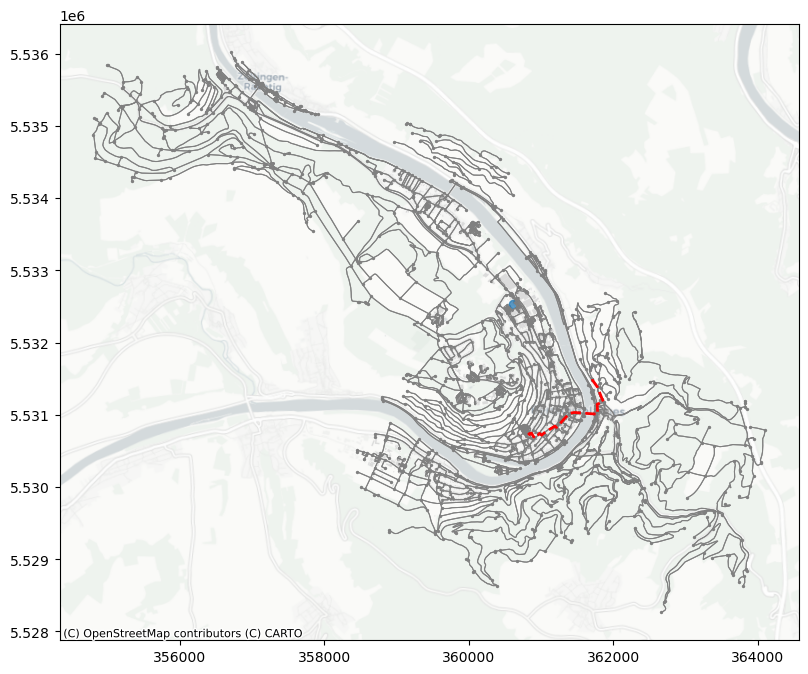

In [84]:
import contextily
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

In [85]:
# see the information about the edges:
# edges.head()
# Columns with invalid values
problematic_columns = [
    "osmid",
    "lanes",
    "name",
    "highway",
    "width",
    "maxspeed",
    "reversed",
    "junction",
    "bridge",
    "tunnel",
    "access",
    "service",
    
]

#  convert selected columns to string format
edges[problematic_columns] = edges[problematic_columns].astype(str)


In [86]:
# save the data
import pathlib
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

Total buildings in buffer: 192
Exported to: /notebooks/data/buildings_along_route.geojson


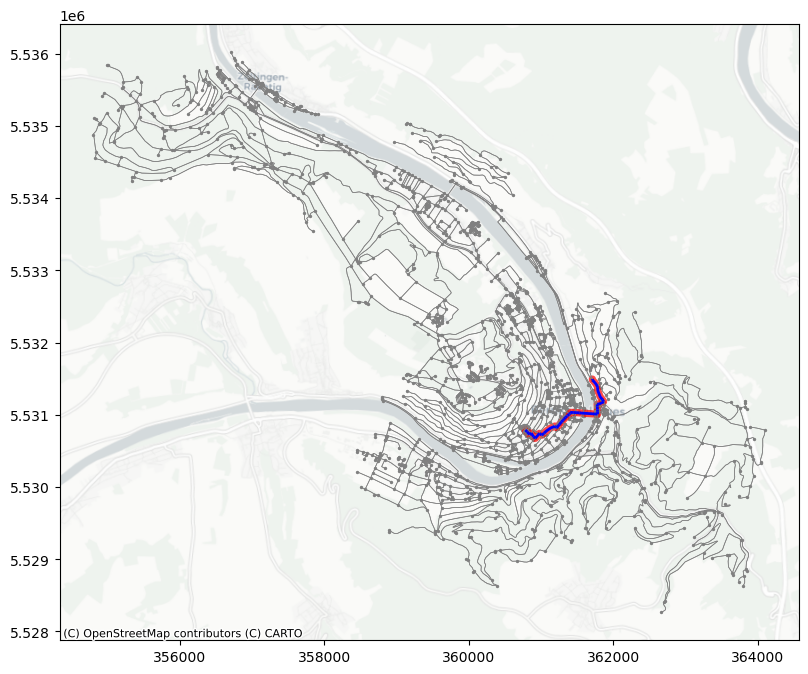

In [87]:
# Task 4 
# 1. Create a 50 m buffer around the route and select buildings intersecting it.
# 2. Count buildings both in total and by building tag within this corridor.
# 3. Export the result to buildings_along_route.geojson.
from shapely.geometry import LineString, Polygon, MultiPolygon

### 1. Buffer ###
# Convert the graph edges into a GeoDataFrame
edges = ox.graph_to_gdfs(graph, nodes=False)

# Get geometry of each edge in the route
edge_geometries = []
for u, v in zip(route[:-1], route[1:]):
    data = graph.get_edge_data(u, v)
    
    # If multiple edges (MultiDiGraph), take the first one
    edge_data = data[0] if isinstance(data, dict) else list(data.values())[0]

    # Append geometry if available
    if 'geometry' in edge_data:
        edge_geometries.append(edge_data['geometry'])
    else:
        # Create straight line between nodes
        point_u = graph.nodes[u]
        point_v = graph.nodes[v]
        edge_geometries.append(LineString([(point_u['x'], point_u['y']), (point_v['x'], point_v['y'])]))

# Merge all edge geometries into a single (Multi-)LineString
route_geom = edge_geometries[0]
for geom in edge_geometries[1:]:
    route_geom = route_geom.union(geom)

# Create GeoDataFrame and the buffer
gdf_route = gpd.GeoDataFrame(geometry=[route_geom], crs=edges.crs)
buffer_geom = gdf_route.buffer(50)  # in meters

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
edges.plot(ax=ax, linewidth=0.5, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')
gdf_route.plot(ax=ax, linewidth=2, color='blue')
buffer_geom.plot(ax=ax, facecolor='red', alpha=0.7)
contextily.add_basemap(ax, crs=edges.crs, source=contextily.providers.CartoDB.Positron) # basemap

### 2. Count of the buildings ###

# Keep only Polygon and MultiPolygon geometries, because earlier I had an error about the different geometry types
buildings = buildings[buildings.geometry.type.isin(['Polygon', 'MultiPolygon'])]

buffer_gdf = gpd.GeoDataFrame(geometry=buffer_geom, crs=edges.crs)
buildings_along_route = gpd.overlay(buildings, buffer_gdf, how='intersection')

# Count
total_buildings = len(buildings_along_route)
print(f"Total buildings in buffer: {total_buildings}")

### 3. Export ###
output_path = DATA_DIRECTORY / "buildings_along_route.geojson"
buildings_along_route.to_file(output_path, driver="GeoJSON")
print(f"Exported to: {output_path}")
